# PINN for ocean circulation
This PINN is designed to predict ocean circulation (velocity in 3d, pressure, and density) from so-called 'state' variables such as temperature, salinity, bottom pressure, and sea surface height which is more easily sampled. We use model data here to simulate the kind of data we might obtain from in-situ sensors. Because these sensors can move throughout the water column, we use an architecture that does not require a uniform grid. 

Unlike other NNs, this PINN is really only designed to be a gap-filler for sparse data. We do not need it to make predictions in time or to other spaces. 

### Loading packages
Some of these are probably unnecessary but they were used in previous iterations...

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
from xgcm import Grid
from os.path import join,expanduser
import ecco_v4_py as ecco
import seaborn as sns
import tensorflow as tf
import scipy.io
import time
import warnings
import matplotlib.colors as colors
import dask
import statsmodels.api as sm
from pyDOE import *
import matplotlib.animation as animation
from IPython.display import HTML
from functools import partial
import sys
import plotly.graph_objects as go

np.random.seed(4321)
tf.set_random_seed(4321)
print('all done')
%matplotlib inline

/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages

all done


### Data loading
We are loading in temperature (THETA), salinity (SALT), east-west/zonal velocity (EVEL), north-south/meridional velocity (NVEL), vertical velocity (WVELMASS), bottom pressure (OBP), sea surface height (SSH), presure anomaly (PHIHYD), and density anomaly (RHOAnoma). Due to memory constraints, we have only loaded in the monthly values from 1992-1993. The data is in 4d-- time, x, y, depth-- and separated into tiles which represent sections of the global map.

We also convert the WVELMASS to WVELMASS_interp. What this means is that we interpolate the vertical velocity from a grid that is offset in the vertical direction onto the regular grid. 

In [2]:
# LOADING IN ECCO GRID + DATA

grid_path = '/projects/SOCCOM/datasets/ecco/Version4/Release4/nctiles_grid/'
ecco_grid = xr.open_dataset(grid_path+'ECCO-GRID.nc')

ds = xr.Dataset()
tags = ['THETA','SALT','EVEL', 'NVEL', 'WVELMASS', 'OBP','SSH','PHIHYD','RHOAnoma'] # used to be PHIHYDcR
    
for i in range(1992,1993):
    for tag in tags:
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            data_path = '/projects/SOCCOM/datasets/ecco/Version4/Release4/nctiles_monthly/'+tag+'/' + str(i) +'/'+tag+'_' + str(i) + '_??.nc'
            dsnow = xr.open_mfdataset(data_path,chunks="auto",data_vars='minimal',coords='minimal', compat='override') 
            ds = xr.merge([ds, dsnow])
#             print('done with '+tag)
    print('the year ' + str(i) + ' is loaded')
ds = xr.merge([ds, ecco_grid])

# download the diffusivity coefficients
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    data_path = '/projects/CDEUTSCH/DATA/OCEAN_3D_MIXING_COEFFS_ECCO_V4r4_native_llc0090.nc'
    dsnow = xr.open_mfdataset(data_path,chunks="auto",data_vars='minimal',coords='minimal', compat='override') 
ds = xr.merge([ds, dsnow])

# # make the XGCM object
xgcm_grid = ecco.get_llc_grid(ds)

# interpolating vertical velocity onto the regular vertical grid
WVELMASS_interp = xgcm_grid.interp(ds.WVELMASS, "Z", boundary='fill')
ds = xr.merge([ds, WVELMASS_interp.rename('WVELMASS_interp')])

# adjusting the pressure anomaly to not be 1/rho
PHI = ds.PHIHYD*(ds.RHOAnoma+1029) # rho_const = 1029
ds = xr.merge([ds, PHI.rename('PHI')])

ds

the year 1992 is loaded


<xarray.Dataset>
Dimensions:          (k: 50, j: 90, i: 90, tile: 13, time: 12, nv: 2, k_l: 50, k_p1: 51, j_g: 90, i_g: 90, k_u: 50)
Coordinates: (12/41)
  * k                (k) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * j                (j) int64 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * i                (i) int64 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile             (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC               (tile, j, i) float32 -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC               (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.08 -88.1
    ...               ...
    hFacS            (k, tile, j_g, i) float32 ...
    hFacC            (k, tile, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacW            (k, tile, j, i_g) float32 ...
    maskW            (k, tile, j, i_g) bool ...
    maskC            (k, tile, j, i) bool False False False ... False False
    maskS            (k, tile, j_g, i) bool ...
Dimensions without coordinates: nv
Data variables:
    THETA            (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    SALT             (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    EVEL             (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    NVEL             (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    WVELMASS         (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    OBP              (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSH              (time, tile, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    PHIHYD           (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    RHOAnoma         (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    WVELMASS_interp  (time, k, tile, j, i) float32 dask.array<chunksize=(1, 49, 13, 90, 90), meta=np.ndarray>
    PHI              (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>

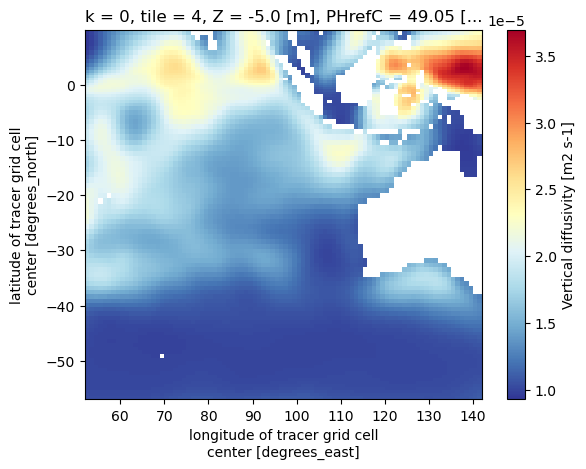

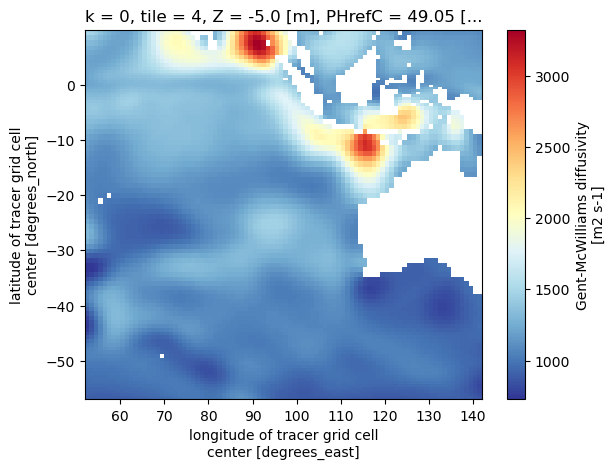

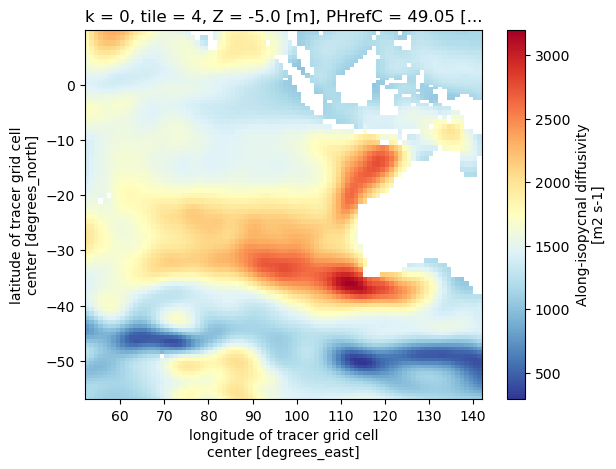

In [10]:
dsnow.DIFFKR.where(ds.maskC).isel(tile=4,k=0).plot(x='XC',y='YC',cmap='RdYlBu_r')
plt.show() # plot longitude vs. latitude
dsnow.KAPGM.where(ds.maskC).isel(tile=4,k=0).plot(x='XC',y='YC',cmap='RdYlBu_r')
plt.show() 
dsnow.KAPREDI.where(ds.maskC).isel(tile=4,k=0).plot(x='XC',y='YC',cmap='RdYlBu_r')
plt.show() 

There are a lot of extra cells here for plotting and looking at some other numbers. If they're commented out, they can just be ignored. 

### Normalizing the data
The data is linearized and scaled to be between -1 and 1. 

ds.XC and ds.YC are longitude and latitude, respectively, so they must be multiplied by some constant to be treated as distances (in units of meters) instead. 

Bottom pressure (OBP) and sea surface height (SSH) are two variables which lack a depth dimension because they refer to a specific depth. As such, their shape is 4d (time, x, y, tile) rather than 5d (time, x, y, z, tile). In order to make up for this discrepancy in dimensions, we make it such that the 4d variables are stacked to become 5d, where the variable values is identical for each depth. 

We also calculate the Coriolis constant (f_nn) in this step, which depends on the latitude. 

The normalized input variables are denoted by 'hat' and the characteristic scales are the uppercase version of the variable. For example, 
$$\hat{x} = \frac{x - x_{min}}{X} - 1 $$
where the characteristic scale is $X = \frac{x_{max} - x_{min}}{2}$. 

In [11]:
# DATA PREPROCESSING (with Navier Stokes normalization)

# gets the index of the array for each dimension before flattening
def using_multiindex(A, columns):
    shape = A.shape
    index = pd.MultiIndex.from_product([range(s) for s in shape], names=columns)
    df = pd.DataFrame({'A': A.flatten()}, index=index).reset_index()
    return df

def make_nninputs(ds, tags, tile_ind, time_ind, depth_ind, j_ind, i_ind, N_train):
    # ds is the main ecco data array
    # tags is a list of strings corresponding to the input variables i.e. ['THETA','SALT', ...]
        # first tagged variable must be in 4d, others can be in 3d
    # tile_ind, depth_ind, j_ind, and i_ind are tuples for subsetted data
    # N_train is a number between 0 and 100 describing percentage of data sampled
    # returns inputs_nn which is an array of all the training data of size N points x [time, depth, lat, lon, tags...]
    # returns coords_nn which is an array of all the training data coordinates of size N points x [time, k, j, i]
    
    subset_template = ds[tags[0]].isel(tile=slice(*tile_ind),time=slice(*time_ind),k=slice(*depth_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC)
    # assuming that only one tile is chosen (OTHERWISE WILL HAVE TO CHANGE CODE)
    inputs_nn = using_multiindex(subset_template.squeeze().values, ['time', 'k', 'j', 'i']) # makes array N x 5 [time, k, j, i, *first tag*]
    inputs_nn = inputs_nn.to_numpy()
    if N_train < 100: # for validation data no need to scramble coordinates
        N_train = int(N_train/100*len(inputs_nn[:,0]))
        train_idx = np.random.choice(len(inputs_nn[:,0]), N_train, replace=False) # Generate a random sample from np.arange(N*T) of size N_train
    else: 
        train_idx = range(len(inputs_nn[:,0]))
    inputs_nn = inputs_nn[train_idx,:] # subsample the training data
    coords_nn = inputs_nn[:,0:4].astype(int) # makes the time,kji indices integers for future use
    inputs_nn = inputs_nn[:,4:] # trim array by cutting out coordinates
    
    for tag in tags:
        if len(ds[tag].shape) == 5: # it is 3d + time + tile dim
            throwaway = ds[tag].where(ds.maskC).isel(tile=slice(*tile_ind),time=slice(*time_ind),k=slice(*depth_ind),j=slice(*j_ind),i=slice(*i_ind)).squeeze().values.flatten()[train_idx,np.newaxis]
            inputs_nn = np.concatenate((inputs_nn, throwaway),axis=1)
        elif len(ds[tag].shape) == 4: # it is 2d + time + tile dim
            throwaway = ds[tag].isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC).values
            throwaway = throwaway.squeeze().flatten()[train_idx,np.newaxis]
            inputs_nn = np.concatenate((inputs_nn, throwaway),axis=1)
            
    inputs_nn = inputs_nn[:,1:] # need to remove the first dummy variable
    
    # assuming that only one tile is chosen (OTHERWISE WILL HAVE TO CHANGE CODE)
    throwaway = ds.XC.isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind))[0,coords_nn[:,2],coords_nn[:,3]].values[1,:].reshape(len(train_idx),1) # get lon coordinates and scale to position
    inputs_nn = np.concatenate((throwaway*111.32*1000,inputs_nn),axis=1)
    # if tile is flipped (evel not uvel), need values[1,:] for YC and values[:,1] for XC
    throwaway = ds.YC.isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind))[0,coords_nn[:,2],coords_nn[:,3]].values[:,1].reshape(len(train_idx),1) # get lat coordinates and scale to position
    f_nn = 2*(2*np.pi)/86164*np.sin(throwaway*np.pi/180) # Coriolis parameter, important for physics
    inputs_nn = np.concatenate((throwaway*111.32*1000,inputs_nn),axis=1)
    throwaway = ds.Z.isel(k=slice(*depth_ind)).values[coords_nn[:,1],np.newaxis] # get depth coordinates
    inputs_nn = np.concatenate((throwaway,inputs_nn),axis=1)
    throwaway = ds.timestep.isel(time=slice(*time_ind)).values[coords_nn[:,0],np.newaxis]*3600 # time in units of seconds
    inputs_nn = np.concatenate((throwaway,inputs_nn),axis=1)

    # normalize by characteristic scales
    lb_nn = np.nanmin(inputs_nn,axis=0) # minimum
    char_nn = (np.nanmax(inputs_nn,axis=0)-lb_nn)/2 # characteristic scales
    inputs_nn = (inputs_nn-lb_nn)/char_nn - 1 # ranges now from -1 to 1
    
    # get rid of the nans after normalizing
    inputs_nn[np.isnan(inputs_nn)] = 0
                                   
    return subset_template, inputs_nn, coords_nn, char_nn, lb_nn, f_nn

### Making the training + validation data
To save memory, we use a slice of the total model data available.

Notice that the training and validation dataset are within the same coordinates. (I call it validation dataset here, but it's actually for testing.) The only difference is that the training data is sparsely sampled (5% of the total area) while the validation dataset is the whole field. 

training dataset is processed!


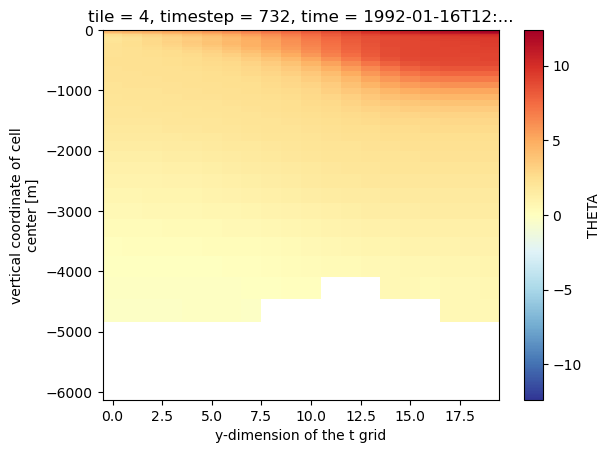

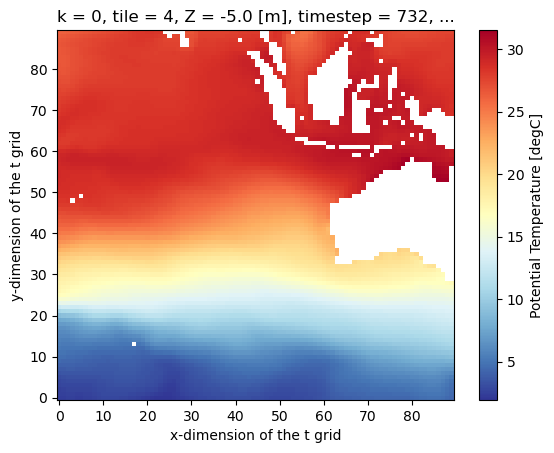

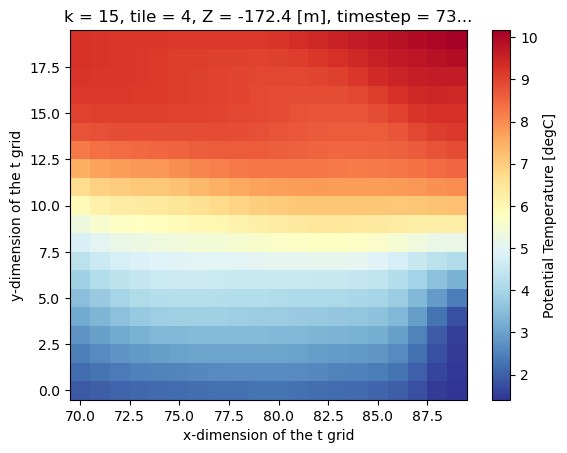

validation dataset is processed!


In [12]:
# MAKE TESTING, VALIDATION, AND TRAINING DATA

# variables to normalize
# tags = ['THETA','SALT','OBP', 'SSH', 'EVEL', 'NVEL','WVELMASS_interp','PHIHYD','RHOAnoma']
tags = ['THETA','SALT','OBP', 'SSH', 'EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma']

# data subset
time_ind = (0,12) # in months
tile_ind = (4,5)
k_ind = (15,25) # depth
j_ind = (0,20) # meridional direction
i_ind = (70,90) # zonal direction

# training dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    # the 5 at the end of the inputs to make_nninputs() means that we randomly sample 5% of the data
    _, inputs_train, coords_train, char_train, lb_train,_ = make_nninputs(ds,tags, tile_ind, time_ind, k_ind, j_ind, i_ind, 5)
print('training dataset is processed!')

# plot zonal velocity for the whole tile + training area
ds.THETA.where(ds.maskC).isel(tile=tile_ind[0],time=0,j=slice(*j_ind),i=slice(*i_ind)).mean('i').plot(x='j',y='Z',cmap='RdYlBu_r')
plt.show() # plot depth vs. latitude
ds.THETA.where(ds.maskC).isel(tile=slice(*tile_ind),time=0,k=0).plot(x='i',y='j',cmap='RdYlBu_r')
plt.show() # plot the entire tile latitude vs. longitude
ds.THETA.where(ds.maskC).isel(tile=slice(*tile_ind),j=slice(*j_ind),i=slice(*i_ind),time=0,k=k_ind[0]).plot(x='i',y='j',cmap='RdYlBu_r')
plt.show() # plot the section we are looking at latitude vs. longitude

# validation dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    subset_template, inputs_val, coords_val, char_val, lb_val, f_val = make_nninputs(ds,tags, tile_ind, time_ind, k_ind, j_ind, i_ind,100) 
print('validation dataset is processed!')

### Collocation point generation
The PINN is trying to minimize the sum of two losses, the data loss and the equation loss. 

The data loss is the typical loss used in vanilla NNs-- the MSE of the prediction compared to the ground truth. Because the data loss requires knowledge of the ground truth, it can only be applied to points where the ground truth is known, i.e. the training data. 

The equation loss, on the other hand, is how well the prediction satisfies some governing physical equation(s) (more details below on the equations themselves). We want to minimize the residual of the physical equations as much as possible which means that the physical equations are satisfied by the prediction. In this case, no knowledge of the ground truth is required so we are not obligated to use the training data, which may be very sparse. Instead, we can choose any number of points to test whether or not the equations are satisfied. These points are called collocation points. 

Note that in the code below, rather than use the collocation points here, we use the validation data (without the variables we are trying to predict) as the collocation points. This is because in its current form, we have generated the collocation points using a Latin hypercube (lhs) set up, which works for coordinates but does not work to generate temperature, salinity, or other state variable data which is not random but rather spatially dependent. 

In [13]:
# # making the collocation points 

# note to self: this needs to change if we include T, S, OBP, and SSH bc we don't know those in relation to coordinates

nCol = int(inputs_val.shape[0])
lb = -np.ones((8,)) # 6 inputs - time, z, y, x, T, S, OBP, SSH
ub = np.ones((8,))
col_train = lb + (ub-lb)*lhs(8, nCol)

# calculate the coriolis constant for the collocation points
throwaway = (col_train[:,2]+1)*char_train[2] + lb_train[2]
f_col = 2*(2*np.pi)/86164*np.sin(throwaway*np.pi/180)
f_col = f_col.reshape((f_col.shape[0],1)).astype('float32')

This is to visualize the distribution of the training and validation data after normalizing. 

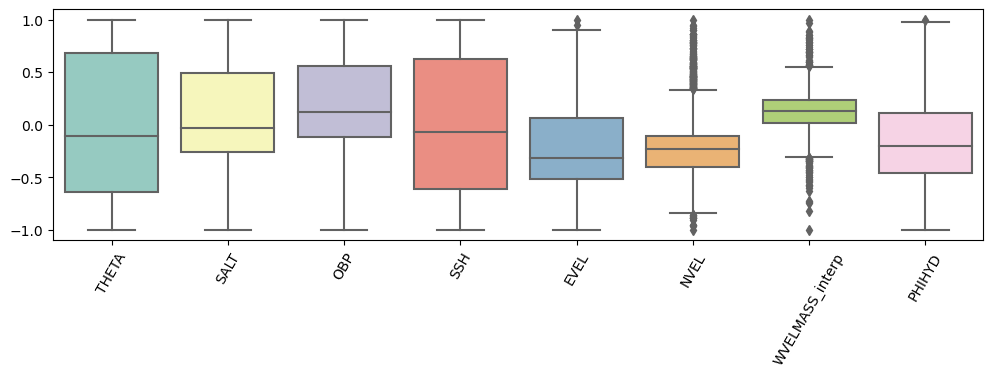

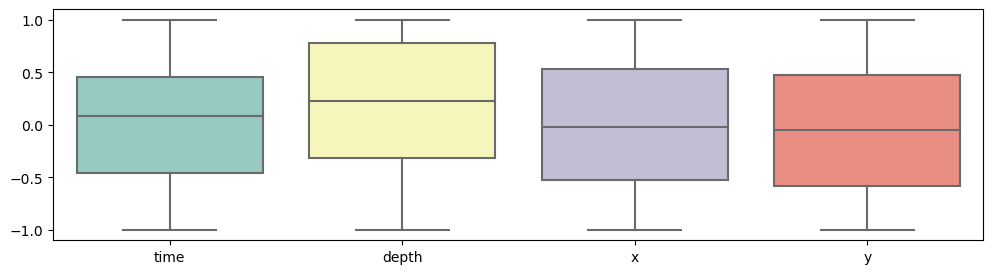

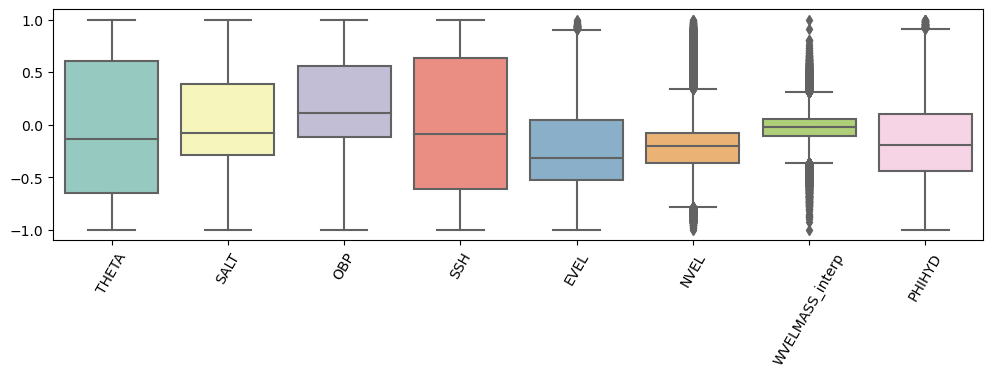

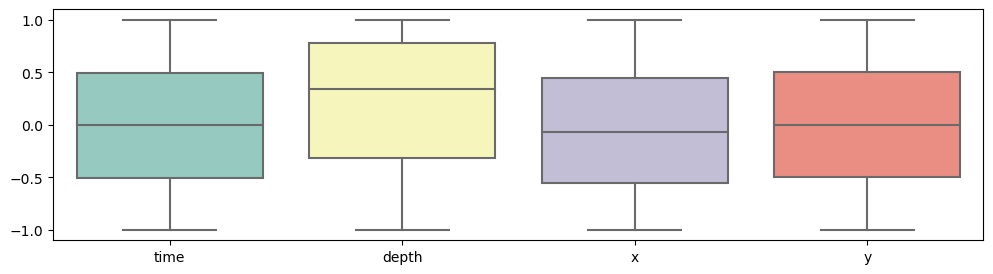

In [6]:
# # plot the normalized version of the training data

# tags = ['THETA','SALT','EVEL', 'NVEL', 'WVELMASS_interp', 'OBP','PHIHYD','SSH']
tags = ['THETA','SALT','OBP', 'SSH', 'EVEL', 'NVEL','WVELMASS_interp','PHIHYD']

fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_train[:,4:12], palette="Set3")
_ = ax.set_xticklabels(tags, rotation=60)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_train[:,0:4], palette="Set3")
_ = ax.set_xticklabels(['time','depth','x','y'], rotation=0)
plt.show()

# plot the normalized version of the validation data as well to make sure distributions match

fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_val[:,4:12], palette="Set3")
_ = ax.set_xticklabels(tags, rotation=60)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.boxplot(data=inputs_val[:,0:4], palette="Set3")
_ = ax.set_xticklabels(['time','depth','x','y'], rotation=0)
plt.show()

### Making the PINN

The training process for the PINN occurs in two stages, first with the Adams optimizer followed by the L-BFGS optimizer. The number of iterations for each kind of optimizer can be specified. 

For our current configuration, we have an input layer (8 inputs) followed by 4 hidden layers of 20 neurons each, and an output layer (5 outputs). 

There are four equations to constrain our output: 

- continuity equation (fcont) $\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} = 0$
- hydrostatic equation (fz) $-\frac{\partial p}{\partial z} - \rho g = 0$
- meridional Navier Stokes momentum equation (fy) $\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + w\frac{\partial v}{\partial z} + fu + \frac{1}{\rho_0}\frac{\partial p}{\partial y} = 0$
- zonal Navier Stokes momentum equation (fx) $\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} + w\frac{\partial u}{\partial z} - fv + \frac{1}{\rho_0}\frac{\partial p}{\partial x} = 0$

The equations in this form are for the dimensional quantities, so the residual (that we are trying to minimize) will also be dimensional. However, the inputs to the PINN are normalized. If we were to put in the input variables as the PINN receives them, the equations here would no longer respect physical scalings because all the inputs range from -1 to 1. 

Recall that the normalized inputs are scaled like $$\hat{x} = \frac{x - x_{min}}{X} - 1 $$

We can then rewrite the dimensional derivatives in terms of the characteristic scales and nondimensional derivatives like so:
$$\frac{\partial u}{\partial x} = \frac{U}{X}\frac{\partial\hat{u}}{\partial\hat{x}}$$

As a result, the dimensional equations can also be rewritten in terms of the characteristic scales and the nondimensional inputs. To illustrate the example, take the continuity equation:
$$\frac{U}{X}\frac{\partial\hat{u}}{\partial\hat{x}} + \frac{V}{Y}\frac{\partial\hat{v}}{\partial\hat{y}} + \frac{W}{Z}\frac{\partial\hat{w}}{\partial\hat{z}} = 0$$
as the alternative form of the dimensional continuity equation. Now, we have equations that should still satisfy physical scalings!

However, an issue remains: the residuals of the dimensional equations (equation loss) have dimensions while the data loss does not because it is calculating the MSE of normalized nondimensional quantities. To address this issue, we convert the equations into their non-dimensional forms by dividing each term with the dimensional coefficient of the largest term. Again using the continuity equation as an example, the nondimensional form is:
$$\frac{Z}{W}\left[\frac{U}{X}\frac{\partial\hat{u}}{\partial\hat{x}} + \frac{V}{Y}\frac{\partial\hat{v}}{\partial\hat{y}} + \frac{W}{Z}\frac{\partial\hat{w}}{\partial\hat{z}}\right] = 0$$

This is the final form of the equation which gets minimized within the PINN.

Note to self: we may need to rescale the quantities outside of the derivatives to be their full dimensional values. 

In [13]:
class PhysicsInformedNN:
    # Initialize the class
    
    def __init__(self, inputs_nn, char_nn, lb_nn, col_nn, layers, f_nn, gamma):
        
        # inputs_nn are the normalized training data
        # char_nn are the characteristic scales of the unnormalized training data
        # lb_nn are the minima of the unnormalized training data
        # col_nn are the normalized collocation points
        # layers are the structure of the PINN
        # f_nn is the coriolis constant for the collocation points
        # gamma is a hyperparameter whose value ranges from 0 to 1 to weigh the overall loss: (1-gamma)*data_loss + gamma*eq_loss

        # Coriolis constants
        self.f_nn = f_nn
        
        X = inputs_nn[:,0:8]
                
        self.X = X
        
        self.char_nn = char_nn
        self.lb_nn = lb_nn
        
        # Training points
        
        self.t = inputs_nn[:,0:1]
        self.k = inputs_nn[:,1:2]
        self.j = inputs_nn[:,2:3]
        self.i = inputs_nn[:,3:4]
    
        self.T = inputs_nn[:,4:5]
        self.S = inputs_nn[:,5:6]
        self.obp = inputs_nn[:,6:7]
        self.ssh = inputs_nn[:,7:8]
        
        self.u = inputs_nn[:,8:9]
        self.v = inputs_nn[:,9:10]
        self.w = inputs_nn[:,10:11]
        self.p = inputs_nn[:,11:12]
        self.rho = inputs_nn[:,12:13]
        
        # Collocation points
        
        self.t_c = col_nn[:,0:1]
        self.k_c = col_nn[:,1:2]
        self.j_c = col_nn[:,2:3]
        self.i_c = col_nn[:,3:4]

        self.T_c = col_nn[:,4:5]
        self.S_c = col_nn[:,5:6]
        self.obp_c = col_nn[:,6:7]
        self.ssh_c = col_nn[:,7:8]
        
        self.layers = layers
        
        # Counter for the reported NS terms
        self.counter = 0
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # training point tf placeholders
        self.i_tf = tf.placeholder(tf.float32, shape=[None, self.i.shape[1]])
        self.j_tf = tf.placeholder(tf.float32, shape=[None, self.j.shape[1]])
        self.k_tf = tf.placeholder(tf.float32, shape=[None, self.k.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.T_tf = tf.placeholder(tf.float32, shape=[None, self.T.shape[1]])
        self.ssh_tf = tf.placeholder(tf.float32, shape=[None, self.ssh.shape[1]])
        self.obp_tf = tf.placeholder(tf.float32, shape=[None, self.obp.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]]) 
        self.w_tf = tf.placeholder(tf.float32, shape=[None, self.w.shape[1]])
        self.p_tf = tf.placeholder(tf.float32, shape=[None, self.p.shape[1]])
        self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        
        # collocation point tf placeholders
        self.i_ctf = tf.placeholder(tf.float32, shape=[None, self.i_c.shape[1]])
        self.j_ctf = tf.placeholder(tf.float32, shape=[None, self.j_c.shape[1]])
        self.k_ctf = tf.placeholder(tf.float32, shape=[None, self.k_c.shape[1]])
        self.t_ctf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])
        
        self.S_ctf = tf.placeholder(tf.float32, shape=[None, self.S_c.shape[1]])
        self.T_ctf = tf.placeholder(tf.float32, shape=[None, self.T_c.shape[1]])
        self.ssh_ctf = tf.placeholder(tf.float32, shape=[None, self.ssh_c.shape[1]])
        self.obp_ctf = tf.placeholder(tf.float32, shape=[None, self.obp_c.shape[1]])

        # observation points
        self.u_pred, self.v_pred, self.w_pred, self.p_pred, self.rho_pred = self.net_NS(self.t_tf, self.k_tf, self.j_tf, self.i_tf, self.T_tf, self.S_tf, self.ssh_tf, self.obp_tf)
        
        # collocation points
        self.fcont, self.fz_pred, self.fv_pred, self.fu_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x, self.u_predictions = self.net_f_NS(self.t_ctf, self.k_ctf, self.j_ctf, self.i_ctf, self.T_ctf, self.S_ctf, self.ssh_ctf, self.obp_ctf)
        
        # losses
        self.eqloss = tf.reduce_mean(tf.square(self.fcont)) + \
                    tf.reduce_mean(tf.square(self.fz_pred)) + \
                    tf.reduce_mean(tf.square(self.fv_pred)) + \
                    tf.reduce_mean(tf.square(self.fu_pred))

        self.dataloss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_mean(tf.square(self.w_tf - self.w_pred)) + \
                    tf.reduce_mean(tf.square(self.p_tf - self.p_pred)) + \
                    tf.reduce_mean(tf.square(self.rho_tf - self.rho_pred))

        self.loss = (1-gamma)*self.dataloss + gamma*self.eqloss
    
        # saved losses
        
        self.losses = []
        self.eq_losses = []
        self.data_losses = []
        self.fu_pred_losses = []
        self.u_t_losses = []
        self.uu_x_losses = []
        self.vu_y_losses = []
        self.wu_z_losses = []
        self.fv_losses = []
        self.p_x_losses = []
        self.u_pred_losses = []
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 9000,  # original maxiter is 50000
                                                                           'maxfun': 50000,
                                                                           'maxcor': 25,
                                                                           'maxls': 25,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss) 
        
        init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.sess.run(init)

    def initialize_NN(self, layers): 
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        # initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in')
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
        # return tf.Variable(initializer(shape=(in_dim, out_dim)), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            # H = tf.keras.activations.selu(tf.add(tf.matmul(H, W), b))
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b) # linear activation function for the last layer
        return Y
        
    def net_f_NS(self, t, k, j, i, T, S, ssh, obp):
        
        # getting equation losses on collocation points
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch the input variables
            tape.watch(t)
            tape.watch(k)
            tape.watch(j)
            tape.watch(i)

            uvwp = self.neural_net(tf.concat([t, k, j, i, T, S, ssh, obp],1),self.weights,self.biases)
            u_hat = uvwp[:,0:1]
            v_hat = uvwp[:,1:2]
            w_hat = uvwp[:,2:3]
            p_hat = uvwp[:,3:4]
            rho_hat = uvwp[:,4:5]
        
        char_nn = self.char_nn
        lb_nn = self.lb_nn

        f = self.f_nn
        
        u_t, u_z, u_y, u_x = tape.gradient(u_hat, [t, k, j, i])
        v_t, v_z, v_y, v_x = tape.gradient(v_hat, [t, k, j, i])
        w_z = tape.gradient(w_hat, k)
        p_z, p_y, p_x = tape.gradient(p_hat, [k, j, i])
        
        u_full = (u_hat+1)*char_nn[8]+lb_nn[8]
        v_full = (v_hat+1)*char_nn[9]+lb_nn[9]
        w_full = (w_hat+1)*char_nn[10]+lb_nn[10]
        rho_full = (rho_hat+1)*char_nn[12]+lb_nn[12]

        fcont = char_nn[1]/char_nn[10]*(char_nn[8]/char_nn[3]*u_x + char_nn[9]/char_nn[2]*v_y + char_nn[10]/char_nn[1]*w_z)
        
        fz = char_nn[1]/char_nn[11]*(-char_nn[11]/char_nn[1]*p_z - rho_full*9.81)
        
        fu = 1029*char_nn[3]/char_nn[11]*(char_nn[8]/char_nn[0]*u_t + char_nn[8]/char_nn[3]*u_full*u_x + char_nn[8]/char_nn[2]*v_full*u_y + char_nn[8]/char_nn[1]*w_full*u_z - f*v_full + char_nn[11]/char_nn[3]/1029*p_x)

        fv = 1029*char_nn[2]/char_nn[11]*(char_nn[9]/char_nn[0]*v_t + char_nn[9]/char_nn[3]*u_full*v_x + char_nn[9]/char_nn[2]*v_full*v_y + char_nn[9]/char_nn[1]*w_full*v_z + f*u_full + char_nn[11]/char_nn[2]/1029*p_y)

        del tape
        
        return fcont, fz, fv, fu, char_nn[8]/char_nn[0]/f/char_nn[9]*u_t, char_nn[8]**2/char_nn[3]/f/char_nn[9]*u_hat*u_x, char_nn[8]/f/char_nn[2]*v_hat*u_y, char_nn[8]*char_nn[10]/char_nn[1]/f/char_nn[9]*w_hat*u_z, -v_hat, char_nn[11]/char_nn[3]/f/char_nn[9]*p_x, u_hat
    
    def net_NS(self, t, k, j, i, T, S, ssh, obp):
        
        # getting data loss on training points
        
        uvwp = self.neural_net(tf.concat([t, k, j, i, T, S, ssh, obp], 1), self.weights, self.biases)
        u_hat = uvwp[:,0:1]
        v_hat = uvwp[:,1:2]
        w_hat = uvwp[:,2:3]
        p_hat = uvwp[:,3:4]
        rho_hat = uvwp[:,4:5]
        
        return u_hat, v_hat, w_hat, p_hat, rho_hat

    def callback(self, loss, dataloss, eqloss, fu_pred, u_t, uu_x, vu_y, wu_z, fv, p_x, u_predictions):
    # def callback(self, loss, dataloss, eqloss, fu_pred):
        
        callback_val = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto',baseline=None)
        
        if self.counter % 100 == 0:
            print('L-BFGS-B It: %d, Loss: %.3e, Data loss: %.3e, Equation loss: %.3e' % (self.counter, loss, dataloss, eqloss))
            self.losses.append(loss)
            self.eq_losses.append(eqloss)
            self.data_losses.append(dataloss)
            self.fu_pred_losses.append(fu_pred)
            self.u_t_losses.append(u_t)
            self.uu_x_losses.append(uu_x)
            self.vu_y_losses.append(vu_y)
            self.wu_z_losses.append(wu_z)
            self.fv_losses.append(fv)
            self.p_x_losses.append(p_x)
            self.u_pred_losses.append(u_predictions)
        
        self.counter = self.counter + 1
        return callback_val
 
    def train(self, nIter): 

        tf_dict = {self.i_tf: self.i, self.j_tf: self.j, self.k_tf: self.k, self.t_tf: self.t, self.S_tf: self.S, self.T_tf: self.T, self.ssh_tf: self.ssh, self.obp_tf: self.obp, self.u_tf: self.u, self.v_tf: self.v, self.w_tf: self.w, self.p_tf: self.p, self.rho_tf: self.rho,\
                   self.i_ctf: self.i_c, self.j_ctf: self.j_c, self.k_ctf: self.k_c, self.t_ctf: self.t_c, self.S_ctf: self.S_c, self.T_ctf: self.T_c, self.ssh_ctf: self.ssh_c, self.obp_ctf: self.obp_c}
        
        start_time = time.time()
        
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                
                loss_value = self.sess.run(self.loss, tf_dict)
                data_value = self.sess.run(self.dataloss, tf_dict)
                eq_value = self.sess.run(self.eqloss, tf_dict)
                elapsed = time.time() - start_time
                
                print('Adam It: %d, Total loss: %.3e, Data loss: %.3e, Equation loss: %.3e, Time: %.2f' % 
                      (it, loss_value, data_value, eq_value, elapsed))
        
                # extra values
                fu_value = self.sess.run(self.fu_pred,tf_dict)
                u_t_value = self.sess.run(self.u_t,tf_dict)
                uu_x_value = self.sess.run(self.uu_x,tf_dict)
                vu_y_value = self.sess.run(self.vu_y,tf_dict)
                wu_z_value = self.sess.run(self.wu_z,tf_dict)
                fv_value = self.sess.run(self.fv,tf_dict)
                p_x_value = self.sess.run(self.p_x,tf_dict)
                u_predictions_value = self.sess.run(self.u_predictions,tf_dict)

                self.losses.append(loss_value)
                self.eq_losses.append(eq_value)
                self.data_losses.append(data_value)
                self.fu_pred_losses.append(fu_value)
                self.u_t_losses.append(u_t_value)
                self.uu_x_losses.append(uu_x_value)
                self.vu_y_losses.append(vu_y_value)
                self.wu_z_losses.append(wu_z_value)
                self.fv_losses.append(fv_value)
                self.p_x_losses.append(p_x_value) 
                self.u_pred_losses.append(u_predictions_value)
                
        self.counter = nIter
                
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                # fetches = [self.loss, self.dataloss, self.eqloss, self.fu_pred],
                                fetches = [self.loss, self.dataloss, self.eqloss, self.fu_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x, self.u_predictions],
#                                 loss_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='auto',verbose=2,baseline=None))
                                loss_callback = self.callback)
        
        # return self.losses, self.eq_losses, self.data_losses, self.fu_pred_losses
        return self.losses, self.eq_losses, self.data_losses, self.fu_pred_losses, self.u_t_losses, self.uu_x_losses, self.vu_y_losses, self.wu_z_losses, self.fv_losses, self.p_x_losses, self.u_pred_losses
    
    def predict(self, t_star, k_star, j_star, i_star, T_star, S_star, ssh_star, obp_star):
        
        tf_dict = {self.i_tf: i_star, self.j_tf: j_star, self.k_tf: k_star, self.t_tf: t_star, self.T_tf: T_star, self.S_tf: S_star, self.ssh_tf: ssh_star, self.obp_tf: obp_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        w_star = self.sess.run(self.w_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        rho_star = self.sess.run(self.rho_pred, tf_dict)

        return u_star, v_star, w_star, p_star, rho_star

    def compute_gradients(self, t, k, j, i, T, S, ssh, obp):
        
        # check that the automatic differentiation matches the numerical differentiation outside of the PINN
        
        tf_dict = {self.i_tf: i, self.j_tf: j, self.k_tf: k, self.t_tf: t, self.S_tf: S, self.T_tf: T, self.ssh_tf: ssh, self.obp_tf: obp}

        with tf.GradientTape(persistent=True) as tape:
            # Watch the input variables
            tape.watch(self.t_tf)
            tape.watch(self.k_tf)
            tape.watch(self.j_tf)
            tape.watch(self.i_tf)

            uvwp = self.neural_net(tf.concat([self.t_tf, self.k_tf, self.j_tf, self.i_tf, self.T_tf, self.S_tf, self.ssh_tf, self.obp_tf], 1), self.weights, self.biases)
            u_hat = uvwp[:,0:1]
            v_hat = uvwp[:,1:2]
            w_hat = uvwp[:,2:3]
            p_hat = uvwp[:,3:4]
            rho_hat = uvwp[:,4:5]

        inputs = [self.t_tf, self.k_tf, self.j_tf, self.i_tf]
#         outputs = [u_hat, v_hat, w_hat, p_hat]

        # Compute the gradients 
        gradients = [self.sess.run(tape.gradient(u_hat, input_var),feed_dict=tf_dict) for input_var in inputs]

        # Clean up the tape
        del tape

        return gradients, self.sess.run(u_hat,feed_dict=tf_dict)
    
    def save_model(self, save_path):
        self.saver.save(self.sess, save_path)
        print('model saved!')

### Training the model
Here, we use 100 iterations of the Adams optimizer and 1000 iterations of the L-BFGS optimizer. The collocation points are the validation points without the prediction variables. $\gamma$ = 0.1, which means that the loss is constrained more heavily by the data loss than satisfying the physical equations.

In [14]:
start_time2 = time.time()

if __name__ == "__main__": 
    
    layers = [8, 20, 20, 20, 20, 5] # first layer should be size of X in the PINN

    model = PhysicsInformedNN(inputs_train, char_train, lb_train, inputs_val[:,0:8].squeeze(), layers, f_val, 0.1)
#     model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, layers, f_col, 0.1)
    nIter = 1000 # number of Adams optimizer training iterations
    # losses, eq_losses, data_losses, eq_res = model.train(nIter)
    losses, eq_losses, data_losses, eq_res, u_t, uu_x, vu_y, wu_z, fv, p_x, u_predictions = model.train(nIter)  # original niter is 200000

print('Total time elapsed', np.round((time.time()-start_time2)/60,3), 'minutes')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Adam It: 0, Total loss: 2.082e+00, Data loss: 8.603e-01, Equation loss: 1.307e+01, Time: 1.69
Adam It: 100, Total loss: 4.348e-01, Data loss: 3.975e-01, Equation loss: 7.703e-01, Time: 51.79


KeyboardInterrupt: 

In [16]:
### MODEL VALIDATION
if __name__ == "__main__": 
    
    t_val = inputs_val[:,0:1]
    z_val = inputs_val[:,1:2]
    y_val = inputs_val[:,2:3]
    x_val = inputs_val[:,3:4]
    T_val = inputs_val[:,4:5]
    S_val = inputs_val[:,5:6] 
    obp_val = inputs_val[:,6:7]
    ssh_val = inputs_val[:,7:8] 
    u_val = inputs_val[:,8:9]
    v_val = inputs_val[:,9:10]
    w_val = inputs_val[:,10:11]
    p_val = inputs_val[:,11:12]
    rho_val = inputs_val[:,12:13]
    
    # model prediction
    u_pred, v_pred, w_pred, p_pred, rho_pred = model.predict(t_val, z_val, y_val, x_val, T_val, S_val, ssh_val, obp_val)
    
    # L2 relative error
    error_u = np.linalg.norm(u_val-u_pred,2)/np.linalg.norm(u_val,2)
    error_v = np.linalg.norm(v_val-v_pred,2)/np.linalg.norm(v_val,2)
    error_w = np.linalg.norm(w_val-w_pred,2)/np.linalg.norm(w_val,2)
    error_p = np.linalg.norm(p_val-p_pred,2)/np.linalg.norm(p_val,2)
    error_rho = np.linalg.norm(rho_val-rho_pred,2)/np.linalg.norm(rho_val,2)
    
    # RMSE (rescaled back to physical units)   
    error_u = np.sqrt(np.square(char_train[8]*(u_val - u_pred)).mean()) #/((u_val+1)*char_val[8] + lb_val[8]).mean())*100
    error_v = np.sqrt(np.square(char_train[9]*(v_val - v_pred)).mean()) #/((v_val+1)*char_val[9] + lb_val[9]).mean())*100
    error_w = np.sqrt(np.square(char_train[10]*(w_val - w_pred)).mean()) #/((w_val+1)*char_val[10] + lb_val[10]).mean())*100
    error_p = np.sqrt(np.square(char_train[11]*(p_val - p_pred)).mean()) #/((p_val+1)*char_val[11] + lb_val[11]).mean())*100
    error_rho = np.sqrt(np.square(char_train[12]*(rho_val - rho_pred)).mean()) #/((rho_val+1)*char_val[12] + lb_val[12]).mean())*100
    
    print('RMSE u [m/s]: %e' % (error_u))    
    print('RMSE v [m/s]: %e' % (error_v))   
    print('RMSE w [m/s]: %e' % (error_w))  
    print('RMSE p anomaly [kg/m/s^2]: %e' % (error_p)) 
    print('RMSE rho anomaly [kg/m^3]: %e' % (error_rho))
    
# final_RMSE = np.array([error_u, error_v, error_w, error_p, error_rho])
# final_RMSE

# from gamma=0.1
# RMSE u [m/s]: 1.345167e-01
# RMSE v [m/s]: 2.350940e-01
# RMSE w [m/s]: 1.321984e+00
# RMSE p anomaly [kg/m/s^2]: 5.277272e-01
# RMSE rho anomaly [kg/m^3]: 6.028671e-02

# for gamma=0.9 + 10000 training iterations, 10 neurons each
# RMSE u [m/s]: 2.287753e-01
# RMSE v [m/s]: 5.706570e-01
# RMSE w [m/s]: 1.277549e+00
# RMSE p anomaly [kg/m/s^2]: 6.575327e-01
# RMSE rho anomaly [kg/m^3]: 7.936490e-02

RMSE u [m/s]: 7.725807e-03
RMSE v [m/s]: 4.697598e-03
RMSE w [m/s]: 2.235166e-06
RMSE p anomaly [kg/m/s^2]: 3.926649e+02
RMSE rho anomaly [kg/m^3]: 6.233326e-02


### Saving the current model / reloading previous models

Saving the model works for all values of $\gamma$>0, but when $\gamma$=0 (pure NN), the saving fails and the next time I run the model, there are nonsensical predictions. 

In [64]:
# ## SAVING THE MODEL
gamma=1
ckpt_file = "./saved-models/50000iter_gamma%03d.ckpt" % gamma
# ckpt_file = "./saved-models/k018_90data_20000iter.ckpt"
array_file = "./saved-models/k018_90data_20000iter.npz"

model.save_model(ckpt_file)
np.savez(array_file, inputs_train=inputs_train, char_train=char_train, lb_train=lb_train, col_train = col_train, f_col = f_col, inputs_val = inputs_val, char_val = char_val, lb_val = lb_val, subset_template = subset_template, layers=layers, coords_val=coords_val, data_losses=data_losses, eq_losses=eq_losses, eq_res=eq_res, u_t=u_t, uu_x=uu_x, vu_y=vu_y, wu_z=wu_z, fv=fv, p_x=p_x, u_predictions=u_predictions)

'./saved-models/50000iter_gamma001.ckpt'

In [54]:
### RELOADING THE MODEL
ckpt_file = "./saved-models/k2035_90data_50000iter_i7090_j7090.ckpt"
array_file = "./saved-models/k2035_90data_50000iter_i7090_j7090.npz"

loaded_data = np.load(array_file) # to load the arrays from the .npz file:

inputs_train=loaded_data['inputs_train']
char_train=loaded_data['char_train']
lb_train=loaded_data['lb_train']
col_train=loaded_data['col_train']
layers=loaded_data['layers']
f_col=loaded_data['f_col']

inputs_val=loaded_data['inputs_val']
coords_val = loaded_data['coords_val']
char_val=loaded_data['char_val']
lb_val=loaded_data['lb_val']
subset_template=loaded_data['subset_template']
layers=loaded_data['layers']
coords_val=loaded_data['coords_val']
data_losses=loaded_data['data_losses']
eq_losses=loaded_data['eq_losses']
eq_res=loaded_data['eq_res']
u_t=loaded_data['u_t']
uu_x=loaded_data['uu_x']
vu_y=loaded_data['vu_y']
wu_z=loaded_data['wu_z']
fv=loaded_data['fv']
p_x=loaded_data['p_x']
u_predictions=loaded_data['u_predictions']

tf.reset_default_graph()
if __name__ == "__main__":  
    model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, layers, f_col)
    model.saver.restore(model.sess, ckpt_file)
    print('model reloaded!')

INFO:tensorflow:Restoring parameters from ./saved-models/k2035_90data_50000iter_i7090_j7090.ckpt
model reloaded!


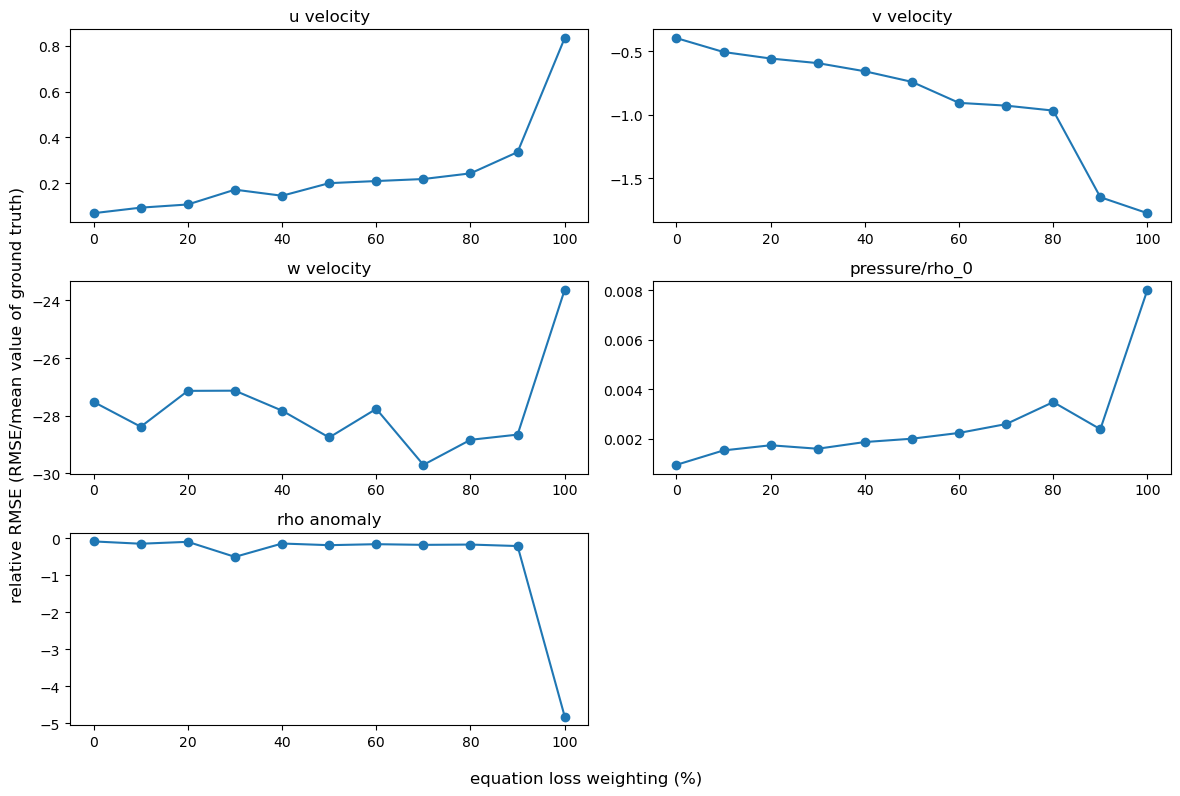

In [73]:
# ### RELOADING THE MODEL (PLOTTING THE ERROR FOR DIFFERENT GAMMA)

# # all_RMSEs = np.zeros((6,len(range(0,110,10))))
# # all_RMSEs[0,:] = list(range(0,110,10))
# # all_RMSEs

# # for i in range(0,11):
# # # ckpt_file = "./saved-models/time012_tile45_k1525_j020_i5090/model_iter50000_gamma%03d.ckpt" % gamma
# #     gamma = i*10
# #     array_file = "./saved-models/time012_tile45_k1525_j020_i5090/model_iter50000_gamma%03d.npz" % gamma
# #     loaded_data = np.load(array_file) # to load the arrays from the .npz file:
# #     final_RMSE=loaded_data['final_RMSE']
# #     all_RMSEs[1:,i]=final_RMSE
    
# # all_RMSEs

# # tags = ['EVEL', 'NVEL','WVELMASS_interp','RHOAnoma','PHIHYD']
# # fig, ax = plt.subplots(1, 1, figsize=(8,5))
# # for i in range(all_RMSEs.shape[0]-1):
# #     throwaway = ds[tags[i]].isel(tile=4,k=slice(15,25),j=slice(0,20),i=slice(50,90)).mean().values
# #     ax.plot(all_RMSEs[0,:], all_RMSEs[i+1,:]/throwaway, 'o-')
    
# # ax.set_xlabel('Equation loss percentage')
# # ax.set_ylabel('Root mean squared error')
# # ax.legend(['u vel','v vel','w vel', 'pressure','density anomaly'])
# # # plt.xticks(rotation=45);

# fig, axs = plt.subplots(3, 2, figsize=(12,8))
# throwaway = ds['EVEL'].isel(tile=4,k=slice(15,25),j=slice(0,20),i=slice(50,90)).mean().values
# axs[0,0].plot(all_RMSEs[0,:], all_RMSEs[1,:]/throwaway, 'o-')
# axs[0,0].set_title('u velocity')
# throwaway = ds['NVEL'].isel(tile=4,k=slice(15,25),j=slice(0,20),i=slice(50,90)).mean().values
# axs[0,1].plot(all_RMSEs[0,:], all_RMSEs[2,:]/throwaway, 'o-')
# axs[0,1].set_title('v velocity')
# throwaway = ds['WVELMASS_interp'].isel(tile=4,k=slice(15,25),j=slice(0,20),i=slice(50,90)).mean().values
# axs[1,0].plot(all_RMSEs[0,:], all_RMSEs[3,:]/throwaway, 'o-')
# axs[1,0].set_title('w velocity')
# throwaway = ds['PHIHYD'].isel(tile=4,k=slice(15,25),j=slice(0,20),i=slice(50,90)).mean().values
# axs[1,1].plot(all_RMSEs[0,:], all_RMSEs[4,:]/throwaway, 'o-')
# axs[1,1].set_title('pressure/rho_0')
# throwaway = ds['RHOAnoma'].isel(tile=4,k=slice(15,25),j=slice(0,20),i=slice(50,90)).mean().values
# axs[2,0].plot(all_RMSEs[0,:], all_RMSEs[5,:]/throwaway, 'o-')
# axs[2,0].set_title('rho anomaly')
# axs[2,1].axis('off')
# fig.supxlabel('equation loss weighting (%)')
# fig.supylabel('relative RMSE (RMSE/mean value of ground truth)')
# plt.tight_layout()

## Visualizing the results 

### Generating animations to show the training process
The individual terms of the zonal Navier Stokes can be plotted in space over the training iterations to see how the predictions are shaped by the equation loss. 

NameError: name 'ds_model' is not defined

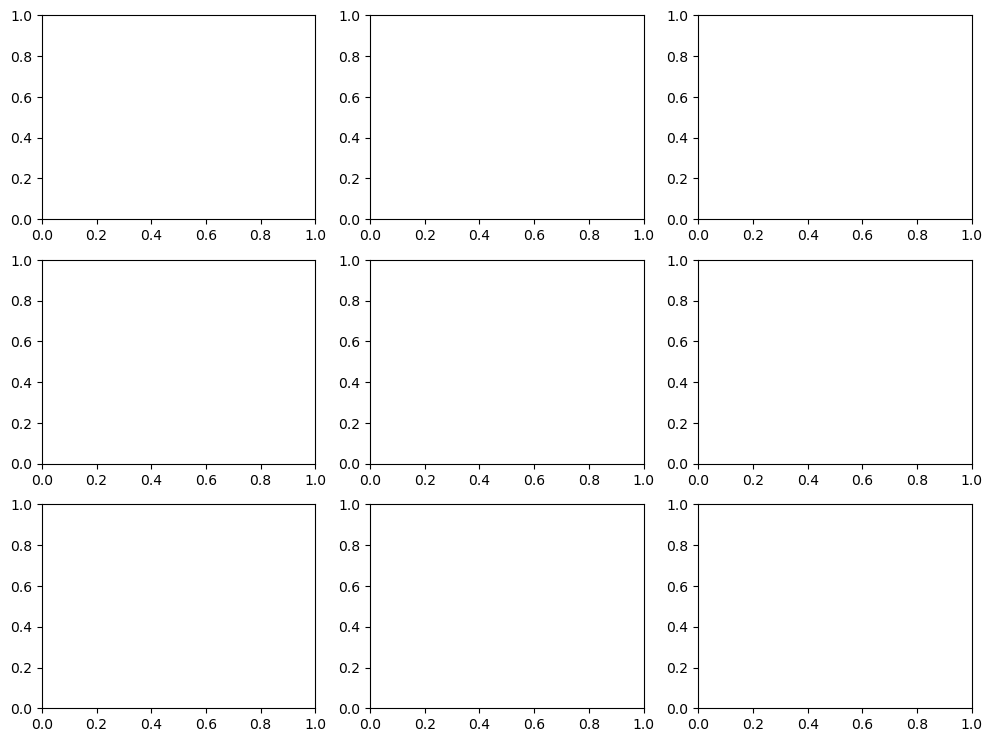

In [8]:
## OLD ANIMATION - WORKS FOR WHEN COLLOCATION POINTS ARE INPUTS_VAL

fig, ax = plt.subplots(3,3,figsize=(12,9))

chosen_depth=28

# picture of ground truth
ds_model.EVEL.isel(time=0,k=chosen_depth).plot(x='XC',y='YC',cmap='RdYlBu_r',vmin=ds_model.EVEL.isel(time=0,k=chosen_depth).min().values,vmax=ds_model.EVEL.isel(time=0,k=chosen_depth).max().values,ax=ax[0,0],cbar_kwargs={'label': 'u velocity [m/s]'})
ax[0,0].set_xlabel('')
ax[0,0].set_xticks([])
ax[0,0].set_title('u velocity (ground truth)')

# picture of the uvel
u_map = ds_model.U_PREDICTIONS.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdYlBu_r',vmin=ds_model.EVEL.isel(time=0,k=chosen_depth).min().values,vmax=ds_model.EVEL.isel(time=0,k=chosen_depth).max().values,ax=ax[0,1],cbar_kwargs={'label': 'u velocity [m/s]'})
# u_map = ds_model.U_PREDICTIONS.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdYlBu_r',ax=ax[0,1],cbar_kwargs={'label': 'u velocity [m/s]'})
ax[0,1].set_xlabel('')
ax[0,1].set_xticks([])
ax[0,1].set_ylabel('')
ax[0,1].set_yticks([])
ax[0,1].set_title('u velocity (prediction)')

# equation residue map
eq_map = ds_model.EQ_RES.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.EQ_RES.isel(time=0,k=chosen_depth,iters=-1).min().values,vmax=ds_model.EQ_RES.isel(time=0,k=chosen_depth,iters=-1).max().values,ax=ax[0,2],cbar_kwargs={'label': ''})
ax[0,2].set_xlabel('')
ax[0,2].set_xticks([])
ax[0,2].set_ylabel('')
ax[0,2].set_yticks([])
ax[0,2].set_title('equation loss')

# mean equation residue scatter
# facet1err = ds_model.EQ_RES.isel(time=0,k=0).mean(['i','j'])
# ax[0,1].scatter(ds_model.iteration[0], facet1err[0], s = 10, color='blue')
# ax[0,1].set_xlabel('iterations')
# # ax[1].set_ylabel('equation residue')
# ax[0,1].set_xlim([0, facet1err.size])
# ax[0,1].set_ylim([ds_model.EQ_RES.isel(time=0,k=0).min(), ds_model.EQ_RES.isel(time=0,k=0).max()])

#
u_t_map = ds_model.U_T.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.U_T.isel(time=0,k=chosen_depth,iters=-1).min(), vmax=ds_model.U_T.isel(time=0,k=chosen_depth,iters=-1).max(), ax=ax[1,0],cbar_kwargs={'label': ''})
# u_t_map = ds_model.U_T.isel(time=0,k=0,iters=500).plot(x='XC',y='YC',cmap='RdBu_r', ax=ax[1,0])#,cbar_kwargs={'label': 'du/dt [m/s^2]'})
ax[1,0].set_xlabel('')
ax[1,0].set_xticks([])
ax[1,0].set_title('du/dt')
uu_x_map = ds_model.UU_X.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.UU_X.isel(time=0,k=chosen_depth,iters=-1).min(), vmax=2*ds_model.UU_X.isel(time=0,k=chosen_depth,iters=-1).max(), ax=ax[1,1],cbar_kwargs={'label': ''})
# uu_x_map = ds_model.UU_X.isel(time=0,k=0,iters=500).plot(x='XC',y='YC',cmap='RdBu_r', ax=ax[1,1])#,cbar_kwargs={'label': 'udu/dx [m/s^2]'})
ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_ylabel('')
ax[1,1].set_yticks([])
ax[1,1].set_title('u du/dx')
vu_y_map = ds_model.VU_Y.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.VU_Y.isel(time=0,k=chosen_depth,iters=-1).min(), vmax=2*ds_model.VU_Y.isel(time=0,k=chosen_depth,iters=-1).max(), ax=ax[1,2],cbar_kwargs={'label': ''})
# vu_y_map = ds_model.VU_Y.isel(time=0,k=0,iters=500).plot(x='XC',y='YC',cmap='RdBu_r', ax=ax[1,2])#,cbar_kwargs={'label': 'vdu/dy [m/s^2]'})
ax[1,2].set_xlabel('')
ax[1,2].set_xticks([])
ax[1,2].set_ylabel('')
ax[1,2].set_yticks([])
ax[1,2].set_title('v du/dy')
wu_z_map = ds_model.WU_Z.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.WU_Z.isel(time=0,k=chosen_depth,iters=-1).min(), vmax=ds_model.WU_Z.isel(time=0,k=chosen_depth,iters=-1).max(), ax=ax[2,0],cbar_kwargs={'label': ''})
# wu_z_map = ds_model.WU_Z.isel(time=0,k=0,iters=500).plot(x='XC',y='YC',cmap='RdBu_r', ax=ax[2,0])#,cbar_kwargs={'label': 'wdu/dz [m/s^2]'})
ax[2,0].set_title('w du/dz')
fv_map = ds_model.FV.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.FV.isel(time=0,k=chosen_depth,iters=-1).min(), vmax=ds_model.FV.isel(time=0,k=chosen_depth,iters=-1).max(), ax=ax[2,1],cbar_kwargs={'label': ''})
# fv_map = ds_model.FV.isel(time=0,k=0,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=ds_model.P_X.isel(time=0,k=0,iters=-1).min(), vmax=2*ds_model.P_X.isel(time=0,k=0,iters=-1).max(), ax=ax[2,1])#,cbar_kwargs={'label': 'fv [m/s^2]'})
ax[2,1].set_ylabel('')
ax[2,1].set_yticks([])
ax[2,1].set_title('-fv')
p_x_map = ds_model.P_X.isel(time=0,k=chosen_depth,iters=0).plot(x='XC',y='YC',cmap='RdBu_r',vmin=-ds_model.FV.isel(time=0,k=chosen_depth,iters=-1).max(), vmax=-ds_model.FV.isel(time=0,k=chosen_depth,iters=-1).min(), ax=ax[2,2],cbar_kwargs={'label': ''})
# p_x_map = ds_model.P_X.isel(time=0,k=0,iters=500).plot(x='XC',y='YC',cmap='RdBu_r', ax=ax[2,2],cbar_kwargs={'label': '1/rho dp/dx [m/s^2]'})
ax[2,2].set_ylabel('')
ax[2,2].set_yticks([])
ax[2,2].set_title('1/rho dp/dx')

fig.suptitle('Iteration 1')


def animate(frame,chosen_depth):
    # change the data for each of the panels
    u_map.set_array(ds_model.U_PREDICTIONS.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    eq_map.set_array(ds_model.EQ_RES.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    u_t_map.set_array(ds_model.U_T.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    uu_x_map.set_array(ds_model.UU_X.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    vu_y_map.set_array(ds_model.VU_Y.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    wu_z_map.set_array(ds_model.WU_Z.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    fv_map.set_array(ds_model.FV.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    p_x_map.set_array(ds_model.P_X.isel(time=0,k=chosen_depth,iters=frame).values.flatten())
    
    # change iteration number
    fig.suptitle("Iteration "+str(100*frame))
#     ax[1].scatter(ds_model.iteration[frame*20], facet1err[frame*20], s = 10, color='blue')

# ani = animation.FuncAnimation(fig, animate, (ds_model.iteration.size)//skip) # len(eq_res)
ani = animation.FuncAnimation(fig, partial(animate,28), ds_model.iteration.size)

# ani.save('./images/all_terms.gif', writer='imagemagick', fps = 5) #Save animation as gif-file

# # display afterwards so that it doesn't mess up the gif
HTML(ani.to_jshtml()) #Show the animation in the kernel

Save the animation, if you would like!

In [13]:
ani.save('./images/iters1_21500_10data_k18.gif', writer='imagemagick', fps = 10) #Save animation as gif-file

### Post-processing of the PINN prediction

Rescale the predictions into their dimensional quantities and remake into Xarray data format. (This step actually comes before the visualization.)

In [8]:
# # PUT THE VELOCITIES INTO A NEW XARRAY
time_ind = (0,12) # in months
tile_ind = (4,5)
k_ind = (15,25) # depth
j_ind = (0,20) # meridional direction
i_ind = (70,90) # zonal direction

# the Navier stokes components only work if the collocation points are also the validation points!!!!!!

subset_template = ds.THETA.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC)
UVEL_pred = (u_pred+1)*char_train[8] + lb_train[8]
VVEL_pred = (v_pred+1)*char_train[9] + lb_train[9]
WVELMASS_pred = (w_pred+1)*char_train[10] + lb_train[10]
P_pred = (p_pred+1)*char_train[11] + lb_train[11]
RHO_pred = (rho_pred+1)*char_train[12] + lb_train[12]

# reshaping back to 4d array
new_size = (np.unique(coords_val[:,0]).size,np.unique(coords_val[:,1]).size,np.unique(coords_val[:,2]).size,np.unique(coords_val[:,3]).size) # size of the original training domain

arrays_to_change = [UVEL_pred, VVEL_pred, WVELMASS_pred, P_pred, RHO_pred] # no iteration data
for i in range(len(arrays_to_change)):
    arrays_to_change[i]= arrays_to_change[i].reshape(new_size)
    
# EQ_RES, U_T, UU_X, VU_Y, WU_Z, FV, P_X, U_PREDICTIONS = [np.zeros(new_size + (len(eq_res),)) for _ in range(8)] # add a new dimension for iterations
# for i in range(len(eq_res)):
#     # reshape each iteration of the model run to be the same shape as domain
#     EQ_RES[:,:,:,:,i] = eq_res[i].reshape(new_size)
#     U_T[:,:,:,:,i] = u_t[i].reshape(new_size)
#     UU_X[:,:,:,:,i] = uu_x[i].reshape(new_size)
#     VU_Y[:,:,:,:,i] = vu_y[i].reshape(new_size)
#     WU_Z[:,:,:,:,i] = wu_z[i].reshape(new_size)
#     FV[:,:,:,:,i] = fv[i].reshape(new_size)
#     P_X[:,:,:,:,i] = p_x[i].reshape(new_size)
#     U_PREDICTIONS[:,:,:,:,i] = u_predictions[i].reshape(new_size)

# U_PREDICTIONS = (U_PREDICTIONS+1)*char_train[8] + lb_train[8]
# arrays_to_change2 = [EQ_RES, U_T, UU_X, VU_Y, WU_Z, FV, P_X, U_PREDICTIONS]
    
# putting the predicted velocities into array to match the size of the model velocities
size_offset = np.array(subset_template.values.squeeze().shape) - np.array(arrays_to_change[0].shape)
# 'pad' the array with 0s to get it to be the same shape
# NOTE you have to change this if you mess with when the training data and testing data is

# these do not have iteration data
for i in range(len(arrays_to_change)):
    array_padding = ((size_offset[0], 0), (0, size_offset[1]), (0, size_offset[2]), (0, size_offset[3]))
    arrays_to_change[i] = np.lib.pad(arrays_to_change[i], array_padding, 'constant', constant_values=(np.nan))

# # these do have iteration data
# for i in range(len(arrays_to_change2)):
#     array_padding = ((size_offset[0], 0), (0, size_offset[1]), (0, size_offset[2]), (0, size_offset[3]), (0, 0))
#     arrays_to_change2[i] = np.lib.pad(arrays_to_change2[i], array_padding, 'constant', constant_values=(np.nan))

# ds_model is a new xarray that contains both predicted velocities and original velocities

tags = ['UVEL_pred', 'VVEL_pred', 'WVELMASS_pred', 'P_pred', 'RHO_pred']
ds_model = xr.zeros_like(subset_template)
for i in range(len(tags)):
    ds_model[tags[i]] = (('time','k','j', 'i'), arrays_to_change[i])
    ds_model[tags[i]] = ds_model[tags[i]].where(ds.maskC.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)))

# ds_model = ds_model.expand_dims(dim={'iters': len(eq_res)}) # add new dimension for model iterations
# ds_model = ds_model.assign_coords(iteration=('iters', range(len(eq_res)))) # add corresponding new coordinate
# tags2 = ['EQ_RES', 'U_T', 'UU_X', 'VU_Y', 'WU_Z', 'FV', 'P_X', 'U_PREDICTIONS']
# for i in range(len(tags2)):
#     ds_model[tags2[i]] = (('time','k','j', 'i','iters'), arrays_to_change2[i])
#     ds_model[tags2[i]] = ds_model[tags2[i]].where(ds.maskC.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)))

ds_model = xr.merge([ds_model, ds.EVEL.where(ds.maskC).isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).NVEL.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).WVELMASS_interp.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).PHI.isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)), ds.RHOAnoma.where(ds.maskC).isel(tile=slice(*tile_ind),k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind))],compat='override')
ds_model = ds_model.reset_coords(tags) # move from coordinate to variable
# ds_model = ds_model.reset_coords(tags2) # move from coordinate to variable

# # set the differences into the output dataset 
ds_model['UVEL_diff'] = ds_model.EVEL - ds_model.UVEL_pred
ds_model['VVEL_diff'] = ds_model.NVEL - ds_model.VVEL_pred 
ds_model['WVELMASS_diff'] = ds_model.WVELMASS_interp - ds_model.WVELMASS_pred 
ds_model['P_diff'] = ds_model.PHI - ds_model.P_pred
ds_model['RHO_diff'] = ds_model.RHOAnoma - ds_model.RHO_pred 
ds_model['UVEL_snr'] = ds_model.EVEL.std(dim='time').load()/ds_model.UVEL_diff.std(dim='time').load()
ds_model['VVEL_snr'] = ds_model.NVEL.std(dim='time').load()/ds_model.VVEL_diff.std(dim='time').load()
ds_model['WVELMASS_snr'] = ds_model.WVELMASS_interp.std(dim='time').load()/ds_model.WVELMASS_diff.std(dim='time').load()
ds_model['P_snr'] = ds_model.PHI.std(dim='time').load()/ds_model.P_diff.std(dim='time').load()
ds_model['RHO_snr'] = ds_model.RHOAnoma.std(dim='time').load()/ds_model.RHO_diff.std(dim='time').load()

print('done with this section!')

done with this section!


In [9]:
### PLOTTING FUNCTIONS
def make_a_quiver(inputs_val, char_val, lb_val, inputs_train, char_train, lb_train, u_pred, v_pred, w_pred):
    fig, axs = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': '3d'})
    
    ### QUIVER PLOT - TRAINING DATA

    # Color by magnitude of velocity
    
    UVEL_pred = (inputs_val[:,8:9]+1)*char_val[8] + lb_val[8]
    VVEL_pred = (inputs_val[:,9:10]+1)*char_val[9] + lb_val[9]
    WVELMASS_pred = (inputs_val[:,10:11]+1)*char_val[10] + lb_val[10]
    x_val = ((inputs_val[:,3:4]+1)*char_val[3] + lb_val[3])/111.32/1000
    y_val = ((inputs_val[:,2:3]+1)*char_val[2] + lb_val[2])/111.32/1000
    z_val = ((inputs_val[:,1:2]+1)*char_val[1] + lb_val[1])

    c = np.sqrt(UVEL_pred**2 + VVEL_pred**2 + WVELMASS_pred**2) # find magnitude of velocity
    c = (c.ravel() - c.min()) / c.ptp() # flatten and normalize
    c = np.concatenate((c, np.repeat(c, 2))) # repeat for each body line and two head lines
    c = plt.cm.RdYlBu_r(c) # colormap

    axs[0].quiver(x_val, y_val, z_val, UVEL_pred, VVEL_pred, WVELMASS_pred, length=0.3, normalize=True, colors=c, cmap='RdYlBu_r', alpha=0.4)
    # Set labels and zticks
    axs[0].set(xlabel='longitude', ylabel='latitude', zlabel='depth')
    axs[0].set_title("True velocities")

    ### QUIVER PLOT - PREDICTION

    # Color by magnitude of velocity
    UVEL_pred = (u_pred+1)*char_train[8] + lb_train[8]
    VVEL_pred = (v_pred+1)*char_train[9] + lb_train[9]
    WVELMASS_pred = (w_pred+1)*char_train[10] + lb_train[10]

    c = np.sqrt(UVEL_pred**2 + VVEL_pred**2 + WVELMASS_pred*2) # find magnitude of velocity
    c = (c.ravel() - c.min()) / c.ptp() # flatten and normalize
    c = np.concatenate((c, np.repeat(c, 2))) # repeat for each body line and two head lines
    c = plt.cm.RdYlBu_r(c) # colormap

    quivers = axs[1].quiver(x_val, y_val, z_val, UVEL_pred, VVEL_pred, WVELMASS_pred, length=0.3, normalize=True, colors=c, cmap='RdYlBu_r', alpha=0.4)
    # Set labels and zticks
    axs[1].set(xlabel='longitude', ylabel='latitude', zlabel='depth')
    axs[0].set_title("Predicted velocities")
    fig.colorbar(quivers, ax=axs.ravel().tolist())
    fig.tight_layout()
    plt.show()
    

def make_a_cube(ds_model, output_type):
    # plot a 3d cube plot of the prediction or training data
    # output type ranges from 0 to 4 for EVEL (0), NVEL (1), WVEL (2), PHIHYD (3), or RHO (4)
    # t_or_p can be training (0) or prediction (1)
    # ex: make_a_cube(ds_model, 3, 0)

    tags = [['EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma'],
            ['UVEL_pred','VVEL_pred','WVELMASS_pred','P_pred','RHO_pred'],
           ['UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff']]

    levels=np.linspace(min(ds_model[tags[0][output_type]].min(),ds_model[tags[1][output_type]].min()).values, max(ds_model[tags[0][output_type]].max(),ds_model[tags[1][output_type]].max()), 20)

    seismic_nanmasked = plt.get_cmap('RdYlBu_r').copy()
    seismic_nanmasked.set_bad('white')

    # Create a figure with 3D ax
    fig, axs = plt.subplots(1, 3, figsize=(24,8), subplot_kw={'projection': '3d'})

    # #Set limits of the plot from coord limits
    xmin, xmax = ds_model.XC.min(), ds_model.XC.max()
    ymin, ymax = ds_model.YC.min(), ds_model.YC.max()
    zmin, zmax = ds.Z.isel(k=k_ind[1]), ds.Z.isel(k=k_ind[0])
    for ax in axs:
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
        # Plot edges
        edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
        ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
        ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
        ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
        # Set labels and zticks
        ax.set(xlabel='longitude', ylabel='latitude', zlabel='depth')

    # TRAINING DATA
    # XY plot
    axs[0].contourf(ds_model.XC.isel(tile=0).values, ds_model.YC.isel(tile=0).values, ds_model[tags[0][output_type]].isel(k=0,time=0, tile=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)
    # ax.contourf(ds.XC.isel(tile=tile_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, ds.YC.isel(tile=tile_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, ds.EVEL.where(ds.maskC).isel(tile=tile_ind[0],time=0,k=k_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

    ## XZ plot
    axs[0].contourf(np.tile(ds_model.XC.isel(j=0,tile=0),(k_ind[1]-k_ind[0],1)), ds_model[tags[0][output_type]].isel(j=0,time=0,tile=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)
    # ax.contourf(np.tile(ds.XC.isel(tile=tile_ind[0],i=slice(*i_ind),j=j_ind[0]),(k_ind[1]-k_ind[0],1)), ds.EVEL.where(ds.maskC).isel(tile=tile_ind[0],i=slice(*i_ind),j=j_ind[0],time=0).values, np.transpose(np.tile(ds.Z,(i_ind[1]-i_ind[0],1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

    ## YZ plot
    axs[0].contourf(ds_model[tags[0][output_type]].isel(i=-1,time=0,tile=0).values, np.tile(ds_model.YC.isel(i=-1,tile=0),(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

    # PREDICTION DATA
    # XY plot
    axs[1].contourf(ds_model.XC.isel(tile=0).values, ds_model.YC.isel(tile=0).values, ds_model[tags[1][output_type]].isel(k=0,time=0, tile=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)
    # ax.contourf(ds.XC.isel(tile=tile_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, ds.YC.isel(tile=tile_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, ds.EVEL.where(ds.maskC).isel(tile=tile_ind[0],time=0,k=k_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

    ## XZ plot
    axs[1].contourf(np.tile(ds_model.XC.isel(j=0,tile=0),(k_ind[1]-k_ind[0],1)), ds_model[tags[1][output_type]].isel(j=0,time=0,tile=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)
    # ax.contourf(np.tile(ds.XC.isel(tile=tile_ind[0],i=slice(*i_ind),j=j_ind[0]),(k_ind[1]-k_ind[0],1)), ds.EVEL.where(ds.maskC).isel(tile=tile_ind[0],i=slice(*i_ind),j=j_ind[0],time=0).values, np.transpose(np.tile(ds.Z,(i_ind[1]-i_ind[0],1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

    ## YZ plot
    C = axs[1].contourf(ds_model[tags[1][output_type]].isel(i=-1,time=0,tile=0).values, np.tile(ds_model.YC.isel(i=-1,tile=0),(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

    # DIFFERENCE DATA
    
    levels=np.linspace(ds_model[tags[2][output_type]].min().values, ds_model[tags[2][output_type]].max(), 20)
    seismic_nanmasked = plt.get_cmap('RdBu_r').copy()
    # norm = colors.TwoSlopeNorm(vmin=ds_model[tags[2][output_type]].min().values, vcenter=0, vmax=ds_model[tags[2][output_type]].max())
    seismic_nanmasked.set_bad('white')
    
    # XY plot
    axs[2].contourf(ds_model.XC.isel(tile=0).values, ds_model.YC.isel(tile=0).values, ds_model[tags[2][output_type]].isel(k=0,time=0, tile=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)#, norm=norm)
    # ax.contourf(ds.XC.isel(tile=tile_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, ds.YC.isel(tile=tile_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, ds.EVEL.where(ds.maskC).isel(tile=tile_ind[0],time=0,k=k_ind[0],i=slice(*i_ind), j=slice(*j_ind)).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

    ## XZ plot
    axs[2].contourf(np.tile(ds_model.XC.isel(j=0,tile=0),(k_ind[1]-k_ind[0],1)), ds_model[tags[2][output_type]].isel(j=0,time=0,tile=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin, cmap=seismic_nanmasked, levels=levels)#, norm=norm)
    # ax.contourf(np.tile(ds.XC.isel(tile=tile_ind[0],i=slice(*i_ind),j=j_ind[0]),(k_ind[1]-k_ind[0],1)), ds.EVEL.where(ds.maskC).isel(tile=tile_ind[0],i=slice(*i_ind),j=j_ind[0],time=0).values, np.transpose(np.tile(ds.Z,(i_ind[1]-i_ind[0],1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

    ## YZ plot
    D = axs[2].contourf(ds_model[tags[2][output_type]].isel(i=-1,time=0,tile=0).values, np.tile(ds_model.YC.isel(i=-1,tile=0),(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax, cmap=seismic_nanmasked, levels=levels)#, norm=norm)

#     # Colorbar
    cbar = fig.colorbar(C, ax=axs[0:2], pad=0.1, label=tags[0][output_type],fraction=0.018)#, orientation='horizontal')
    # cbar.ax.tick_params(labelsize=22)
    fig.colorbar(D, ax=axs[2],pad=0.1, label=tags[2][output_type],fraction=0.04)
    
    axs[0].set_title("True "+tags[0][output_type])
    axs[1].set_title("Predicted "+tags[0][output_type])
    axs[2].set_title("True - predicted "+tags[0][output_type])

    # Show Figure
    # fig.tight_layout()
    plt.show()

### Plot the prediction in longitude vs. latitude vs. depth cube

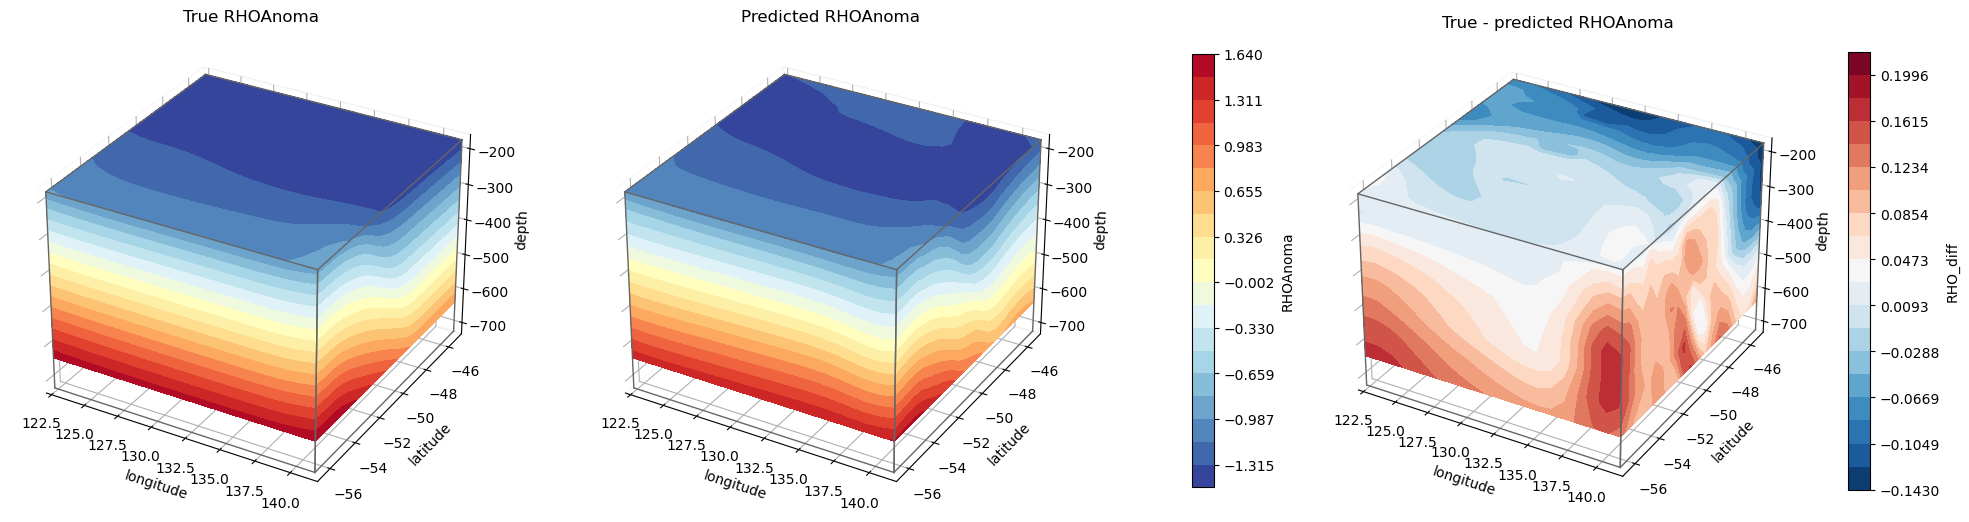

In [14]:
### TESTING THE PLOTTING FUNCTIONS
# make_a_quiver(inputs_val, char_val, lb_val, inputs_train, char_train, lb_train, u_pred, v_pred, w_pred)
make_a_cube(ds_model, 4)

### Plot latitude vs. longitude plots of the truth, prediction, signal-to-noise ratio, and differences
The overall columns are the time steps and the overall rows are depths.

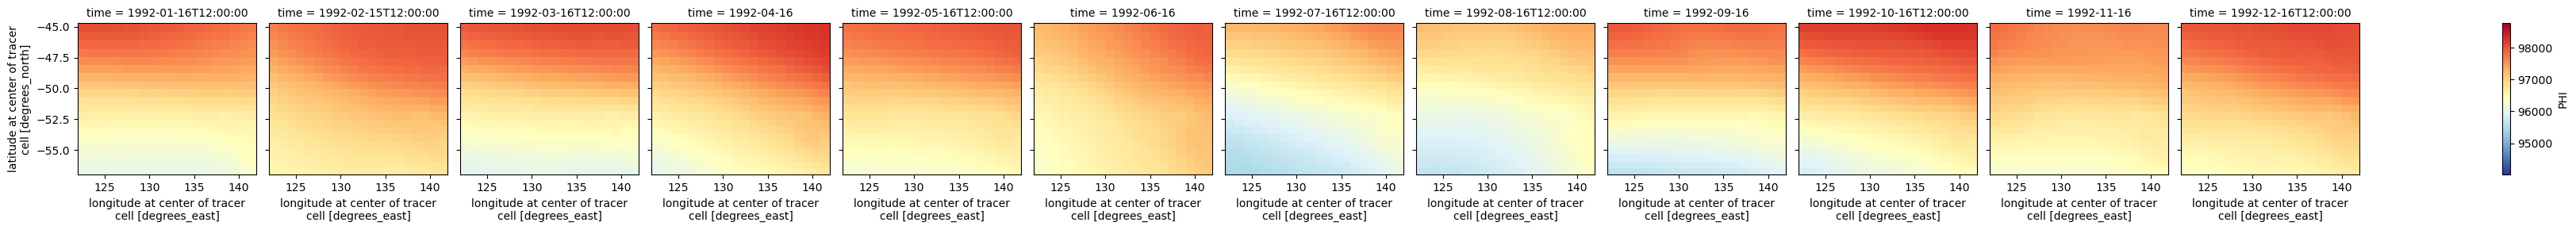

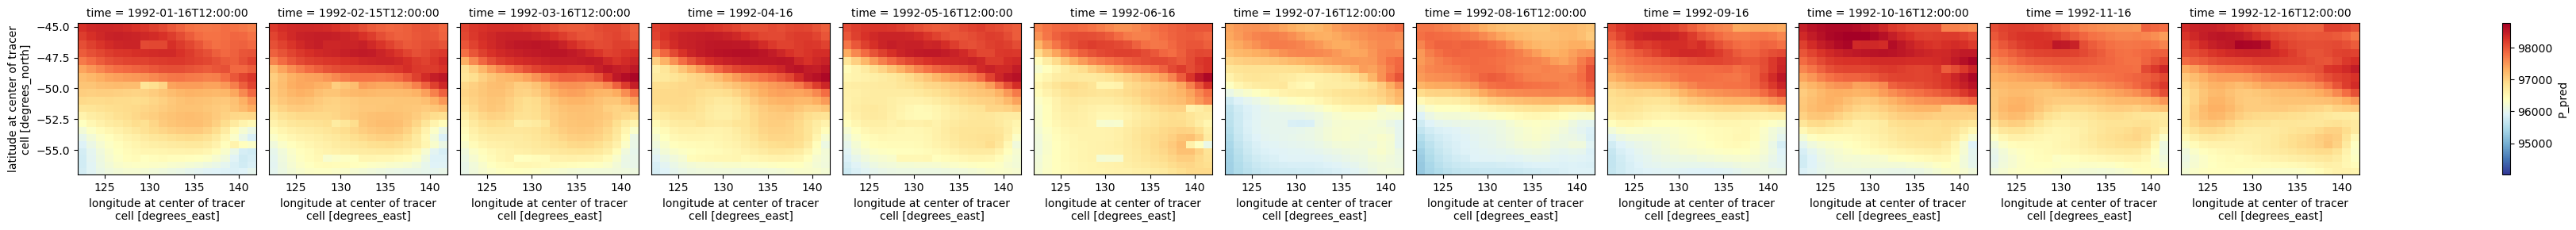

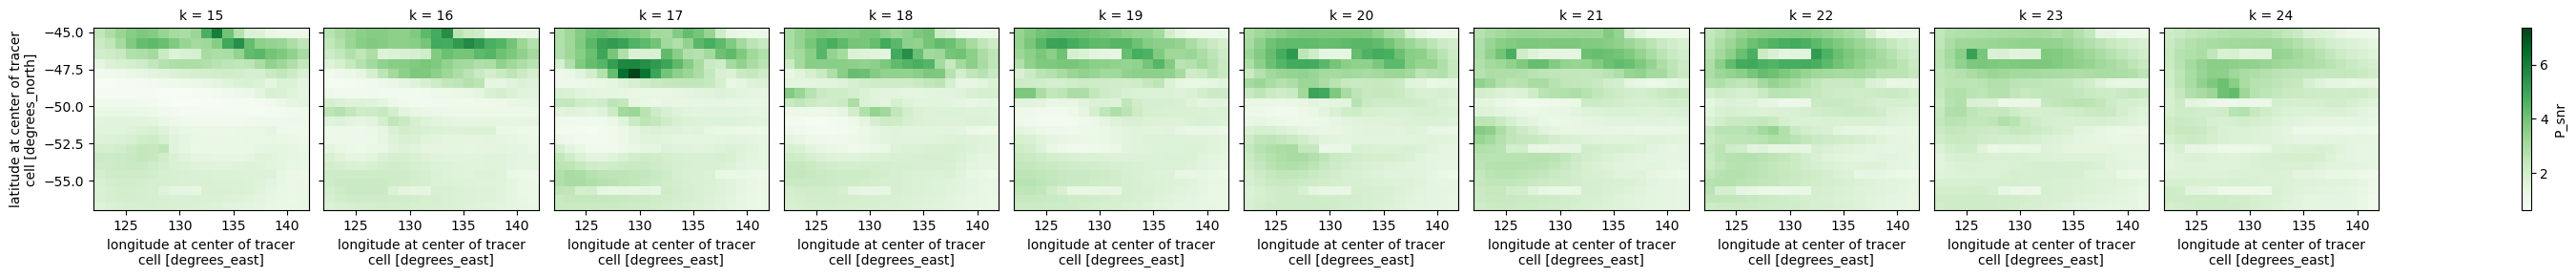

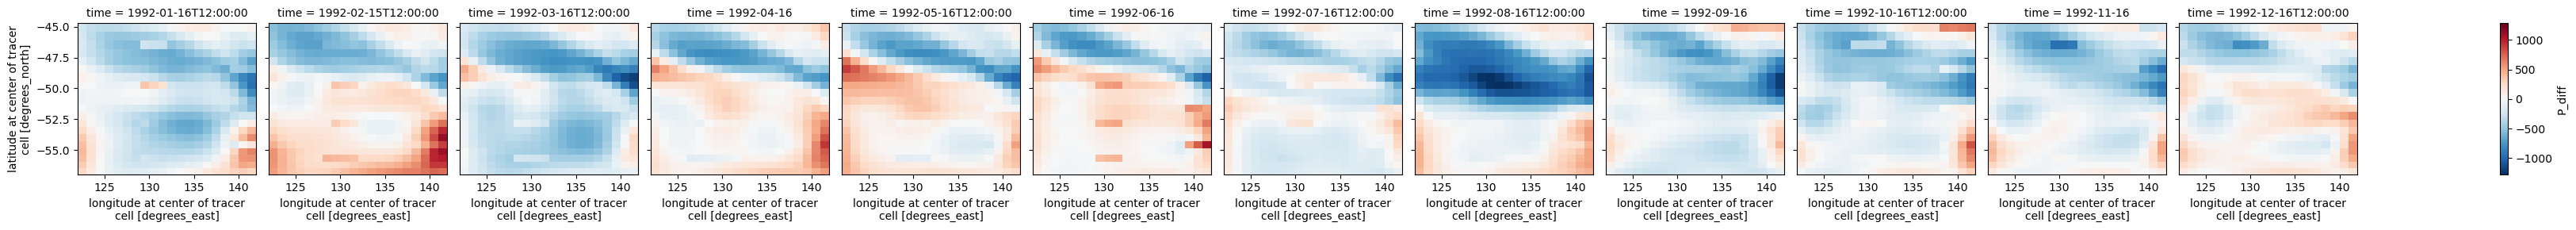

In [18]:
# make a mega plot of 4d data of zonal velocity

tags = [['EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma'],
        ['UVEL_pred','VVEL_pred','WVELMASS_pred','P_pred','RHO_pred'],
        ['UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff'],
       ['UVEL_snr','VVEL_snr','WVELMASS_snr','P_snr','RHO_snr']]

output_type = 3
tag_true = tags[0][output_type]
tag_pred = tags[1][output_type]
tag_diff = tags[2][output_type]
tag_snr = tags[3][output_type]

chosen_depth=15
# # # each row of plots is a depth, each column is a time
vmin = min(ds_model[tag_true].min(),ds_model[tag_pred].min()).values
vmax = max(ds_model[tag_true].max(),ds_model[tag_pred].max()).values
ds_model[tag_true].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='XC', y='YC', col='time', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
ds_model[tag_pred].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='XC', y='YC', col='time', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
ds_model[tag_snr].plot(x='XC', y='YC', col='k',cmap='Greens')
ds_model[tag_diff].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='XC', y='YC', col='time')
plt.show()


### Plot the equation and data losses over the training iterations

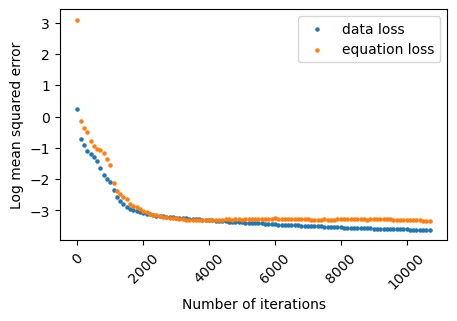

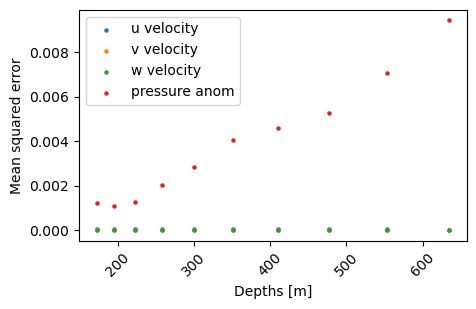

In [15]:
######## Losses after each iteration #######################
########           ########### 
fig, ax = plt.subplots(1, 1, figsize=(5,3))
iterations = list(range(0,len(data_losses)))
iterations = [i * 100 for i in iterations]
ax.scatter(iterations, np.log(data_losses), s = 5)
ax.scatter(iterations, np.log(eq_losses), s = 5)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Log mean squared error')
ax.legend(['data loss','equation loss'])
plt.xticks(rotation=45);


fig, ax = plt.subplots(1, 1, figsize=(5,3))
depths = -1*ds.Z.isel(k=slice(*k_ind))
# tags = [['EVEL','NVEL','WVELMASS_interp','PHIHYD','RHOAnoma'],
        # ['UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff']]
tags = [['EVEL','NVEL','WVELMASS_interp','RHOAnoma'],
    ['UVEL_diff','VVEL_diff','WVELMASS_diff','RHO_diff']]
for i in range(len(tags[1])): 
    throwaway = ds_model[tags[1][i]]#/ds_model[tags[0][i]] # diff/actual
    throwaway = throwaway*throwaway
    # throwaway = throwaway/ds_model[tags[0][i]] # RMPSE as percentage
    throwaway = throwaway.mean(['i','j','time'])
    ax.scatter(depths, throwaway, s = 5)
# ax.scatter(depths, ds_model['P_diff'].mean(['i','j','time']), s = 5)
# ax.scatter(depths, ds_model['RHO_diff'].mean(['i','j','time']), s = 5)
ax.set_xlabel('Depths [m]')
ax.set_ylabel('Mean squared error')
ax.legend(['u velocity','v velocity','w velocity','pressure anom', 'density anom'])
plt.xticks(rotation=45);
